In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    ReduceLROnPlateau,
    EarlyStopping,
    TensorBoard,
)
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.regularizers import l2
from tensorflow.compat.v2.keras.layers import BatchNormalization
from tensorflow.python.client import device_lib
from utils import *
from models.resnet import *

In [3]:
np.random.seed(1)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15644305416587029307
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3156787200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7509853080228481431
physical_device_desc: "device: 0, name: GeForce GTX 980M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


# Loading images

In [4]:
train_folder_img = "data/training/images/"
train_folder_gt = "data/training/groundtruth/"

filenames = os.listdir(train_folder_img)
n_train = len(filenames)
print(f"Load images and groundtruth for train: {n_train} ")

img_train = [load_img(train_folder_img+filenames[i]) for i in range(n_train)] 
gt_train = [load_img(train_folder_gt+filenames[i]) for i in range(n_train)] 

img_train = np.asarray(img_train)
gt_train = np.asarray(gt_train)

Load images and groundtruth for train: 80 


In [5]:
val_folder_img = "data/validating/images/"
val_folder_gt = "data/validating/groundtruth/"

filenames = os.listdir(val_folder_img)
n_val = len(filenames)
print(f"Load images and groundtruth for validation: {n_val} ")

img_val = [load_img(val_folder_img+filenames[i]) for i in range(n_val)] 
gt_val = [load_img(val_folder_gt+filenames[i]) for i in range(n_val)] 

img_val = np.asarray(img_val)
gt_val = np.asarray(gt_val)

Load images and groundtruth for validation: 20 


In [6]:
img_train.shape

(80, 400, 400, 3)

In [7]:
gt_train.shape

(80, 400, 400)

In [8]:
img_val.shape

(20, 400, 400, 3)

In [9]:
gt_val.shape

(20, 400, 400)

In [10]:
X_train, Y_train = imag_rotation_aug(img_train, gt_train)

In [11]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [12]:
print(X_train.shape)
print(Y_train.shape)
n_train = Y_train.shape[0]

(720, 448, 448, 3)
(720, 448, 448)


In [13]:
X_val, Y_val = imag_rotation_aug(img_val,gt_val)

In [14]:
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)

In [15]:
print(X_val.shape)
print(Y_val.shape)
n_val = Y_val.shape[0]

(180, 448, 448, 3)
(180, 448, 448)


# ResNet-UNet Architecture

In [16]:
data_aug_factor = 1
batch_normalization = False
activation = "relu"
dropout = 0
amsgrad = False
lr = 1e-4
BATCH_SIZE = 100
WINDOW_SIZE = 64
PATCH_SIZE = 16
EPOCHS = 80
STEPS_PER_EPOCH = 100
WIDTH = 448

In [17]:
model = resnet_unet_model(
    shape=(64, 64, 3),
    batch_normalization=batch_normalization,
    activation=activation,
    dropout=dropout,
    amsgrad=amsgrad,
    lr=lr,
    BATCH_SIZE=BATCH_SIZE,
    WINDOW_SIZE=WINDOW_SIZE,
    PATCH_SIZE=PATCH_SIZE,
    EPOCHS=EPOCHS,
    STEPS_PER_EPOCH=STEPS_PER_EPOCH,
    WIDTH=WIDTH,
)

# Train the Model


In [18]:
# Train the model
history = model.train(
    X_train, Y_train, n_train, X_val, Y_val, n_val
)
model.save("best_resnet_unet_data_aug.h5")

Epoch 1/80
 99/100 [============================>.] - ETA: 0s - loss: 0.4931 - accuracy: 0.7627 - recall: 0.7606 - f1: 0.7627
Epoch 00001: val_loss improved from inf to 3.77969, saving model to best_resnet_unet.h5
100/100 [==============================] - 69s 689ms/step - loss: 0.4917 - accuracy: 0.7627 - recall: 0.7602 - f1: 0.7626 - val_loss: 3.7797 - val_accuracy: 0.7513 - val_recall: 0.7513 - val_f1: 0.7513
Epoch 2/80
 99/100 [============================>.] - ETA: 0s - loss: 0.3195 - accuracy: 0.8599 - recall: 0.8572 - f1: 0.8595
Epoch 00002: val_loss improved from 3.77969 to 0.97835, saving model to best_resnet_unet.h5
100/100 [==============================] - 65s 652ms/step - loss: 0.3188 - accuracy: 0.8603 - recall: 0.8576 - f1: 0.8598 - val_loss: 0.9784 - val_accuracy: 0.7470 - val_recall: 0.7470 - val_f1: 0.7470
Epoch 3/80
 99/100 [============================>.] - ETA: 0s - loss: 0.2647 - accuracy: 0.8954 - recall: 0.8955 - f1: 0.8954
Epoch 00003: val_loss improved from 0.

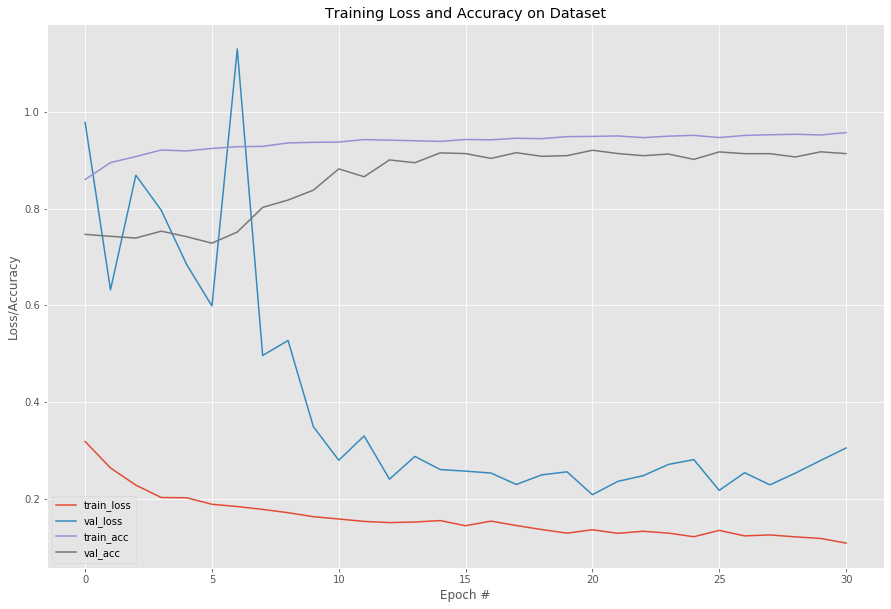

In [19]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"][1:], label="train_loss")
plt.plot(history.history["val_loss"][1:], label="val_loss")

# If running on Google Colab use val_acc, if not val_accuracy
plt.plot(history.history["accuracy"][1:], label="train_acc")
plt.plot(history.history["val_accuracy"][1:], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("resnet_unet.pdf")
plt.show()

In [20]:
model = resnet_unet_model(
    shape=(64, 64, 3),
    batch_normalization=batch_normalization,
    activation=activation,
    dropout=dropout,
    amsgrad=amsgrad,
    lr=lr,
    BATCH_SIZE=BATCH_SIZE,
    WINDOW_SIZE=WINDOW_SIZE,
    PATCH_SIZE=PATCH_SIZE,
    EPOCHS=EPOCHS,
    STEPS_PER_EPOCH=STEPS_PER_EPOCH,
    WIDTH=WIDTH,
)
model.load("best_resnet_unet.h5")
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)
submission_filename = "resnet_unet_data_augmentation.csv"
generate_submission(model, submission_filename, *image_filenames)

Generating predictions for image:  data/test_set_images/test_1/test_1.png
Generating predictions for image:  data/test_set_images/test_2/test_2.png
Generating predictions for image:  data/test_set_images/test_3/test_3.png
Generating predictions for image:  data/test_set_images/test_4/test_4.png
Generating predictions for image:  data/test_set_images/test_5/test_5.png
Generating predictions for image:  data/test_set_images/test_6/test_6.png
Generating predictions for image:  data/test_set_images/test_7/test_7.png
Generating predictions for image:  data/test_set_images/test_8/test_8.png
Generating predictions for image:  data/test_set_images/test_9/test_9.png
Generating predictions for image:  data/test_set_images/test_10/test_10.png
Generating predictions for image:  data/test_set_images/test_11/test_11.png
Generating predictions for image:  data/test_set_images/test_12/test_12.png
Generating predictions for image:  data/test_set_images/test_13/test_13.png
Generating predictions for ima